In [1]:
import metview as mv

import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature#
import cdsapi
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
import os



In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = os.getenv("CDS_API_KEY")
KEY = os.getenv("CDS_UID")
c = cdsapi.Client()
#c = cdsapi.Client(url=URL, key=KEY)
DATADIR = './'

# this seems to be lat, lon, lat, lon for upper and lower corner??
area_europe = [72, -25, 34,40]
area_greenland = [85,-75,60,-10]
years = ["2023"]
out_cds=os.path.join(DATADIR,'era5_monthly_t2m_greenland.nc')
ofiles=[]
ofiles.append(out_cds)

In [3]:
if not os.path.isfile(out_cds):
    
    c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': years,
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': area_greenland,
        'format': 'netcdf',
    },
    out_cds)
else:
    print(f"{out_cds} already there")


./era5_monthly_t2m_greenland.nc already there


In [4]:
out_cds=os.path.join(DATADIR,'era5_monthly_tp_greenland.nc')
ofiles.append(out_cds)

In [5]:
if not os.path.isfile(out_cds):
    c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'total_precipitation',#['maximum_2m_temperature_since_previous_post_processing'],
        'year': years,
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': area_greenland,
        'format': 'netcdf',
    },
    out_cds)
else:
    print(f"{out_cds} already there")


./era5_monthly_tp_greenland.nc already there


In [38]:
input_var={"t2m":ofiles[0],"tp":ofiles[1]}
ds = xr.open_dataset(input_var["tp"])
ds


<xarray.Dataset>
Dimensions:    (longitude: 261, latitude: 101, expver: 2, time: 5)
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -10.5 -10.25 -10.0
  * latitude   (latitude) float32 85.0 84.75 84.5 84.25 ... 60.5 60.25 60.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-05-01
Data variables:
    tp         (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-26 17:07:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [39]:
#ds.longitude

In [42]:
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
# Create Xarray Data Array
da = ds_180['tp']*1000 #*24

da_tp = da.assign_attrs(da.attrs)
da_tp.attrs['units'] = 'mm or kg/m2'
import matplotlib as mpl
cmap = mpl.cm.coolwarm
#cmap = mpl.cm.RdBu_r


In [43]:
da_tp[0,0,:,:].max()

<xarray.DataArray 'tp' ()>
array(8.41704273)
Coordinates:
    expver   int32 1
    time     datetime64[ns] 2023-01-01

In [44]:
da_tp[0,0,:,:].min()

<xarray.DataArray 'tp' ()>
array(0.09356113)
Coordinates:
    expver   int32 1
    time     datetime64[ns] 2023-01-01

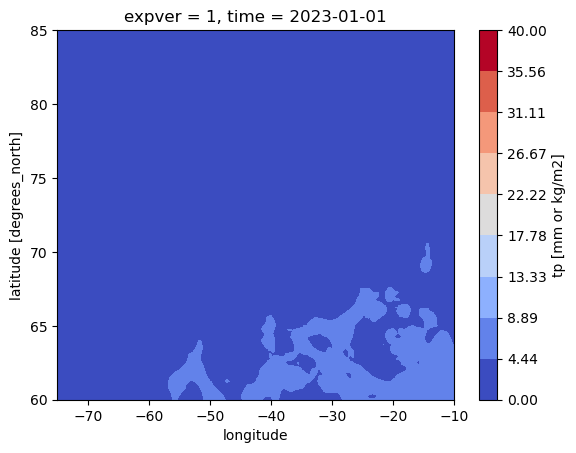

In [45]:
levels=np.linspace(0,40,10) #0,0.010,10)#  0,0.2,10 ) # 0.001,0.010,10)
da_tp[0,0,:,:].plot.contourf(cmap=cmap,levels=levels)

In [25]:
ds = xr.open_dataset(os.path.join(DATADIR,'era5_monthly_t2m_greenland.nc'))
ds

<xarray.Dataset>
Dimensions:    (longitude: 261, latitude: 101, expver: 2, time: 5)
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -10.5 -10.25 -10.0
  * latitude   (latitude) float32 85.0 84.75 84.5 84.25 ... 60.5 60.25 60.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-05-01
Data variables:
    t2m        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-27 14:38:43 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [26]:
fig = plt.figure(figsize=[12,9])


<Figure size 1200x900 with 0 Axes>

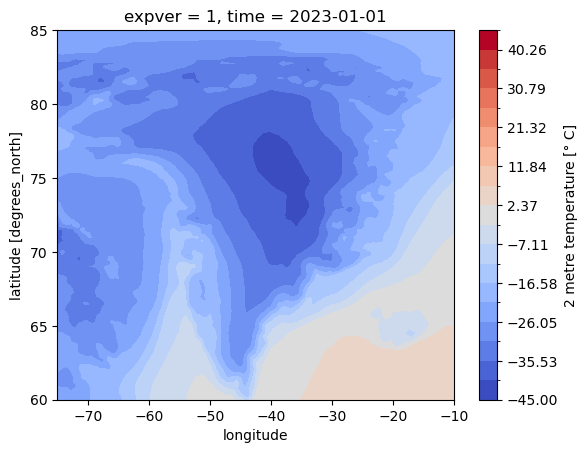

In [27]:
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
# Create Xarray Data Array
da = ds_180['t2m']
# Create Xarray Data Array
da_degc = ds['t2m'] - 273.15
da_degc = da - 273.15
da_degc = da_degc.assign_attrs(da.attrs)
da_degc.attrs['units'] = '° C'
import matplotlib as mpl
cmap = mpl.cm.coolwarm
#cmap = mpl.cm.RdBu_r
levels=np.linspace(-45,45,20)

da_degc[0,0,:,:].plot.contourf(cmap=cmap,levels=levels)
#type(da_degc[0,:,:])

# here comes the data from CARRA

In [28]:
# Now for CARRA
#data from carra not in Mars or CDS, reading locally
#fin_carra="t2m-mean_carra-20210101-20210131.grib2"
#carra = mv.read(fin_carra)

import metview as mv
fin_carra=os.path.join(DATADIR,"means_gribmean","t2m_mean.grib2")

carra = mv.read(fin_carra)
ds_carra = carra.to_dataset()
ds_carra

<xarray.Dataset>
Dimensions:            (y: 1269, x: 1069)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2023-06-29T12:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [29]:
ds_carra["t2m"] = ds_carra["t2m"] -  273.15
da_carra = ds_carra["t2m"]
#lats=da_carra["longitude"].to_dataframe()#["latitude"]
#lons=da_carra["longitude"].to_dataframe()#["longitude"]
#x=da_carra["longitude"].to_array()
#y=da_carra["latitude"].to_array()
#da_carra.longitude
#get_coords = ds.assign_coords(longitude=(((da_carra.longitude + 180) % 360) - 180)).sortby('longitude')
#ds_carra.longitude

In [30]:
#lats["latitude"]
test=da_carra.to_dataframe()
lats=test["latitude"].values
lons=test["longitude"].values

In [31]:
nx=1069
ny=1269
#lats=lats.reshape((nx,ny))
#lons=lons.reshape((nx,ny))
lats

array([55.81      , 55.8174602 , 55.82490826, ..., 77.86645179,
       77.8454289 , 77.82440048])

1269

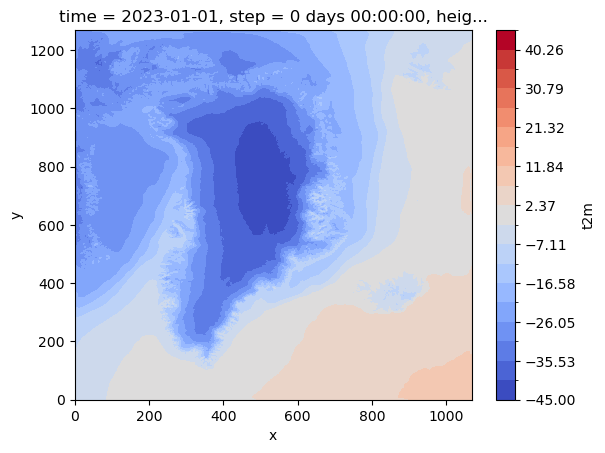

In [32]:
#ds_carra["t2m"].plot()# x=ds_carra["longitude"],y=ds_carra["latitude"])
#levels=np.linspace(-45,45,10)
da_carra.plot.contourf(cmap=cmap,levels=levels)#,x=ds_carra.latitude.values,y=ds_carra.longitude.values)
#help(da_carra.plot.contourf)
len(da_carra.latitude.values)

In [33]:
fin_carra=os.path.join(DATADIR,"means_gribmean","tp_carra_202301.grib2")

carra = mv.read(fin_carra)
ds_carra = carra.to_dataset()
ds_carra["tp"] = ds_carra["tp"]#/86400 #*31/1000

ds_carra

<xarray.Dataset>
Dimensions:     (y: 1269, x: 1069)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    tp          (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2023-06-29T12:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [34]:
da_carra = ds_carra["tp"]
test=da_carra.to_dataframe()
lats=test["latitude"].values
lons=test["longitude"].values
da_carra.max()

<xarray.DataArray 'tp' ()>
array(36.08684921)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

In [35]:
da_carra.min()

<xarray.DataArray 'tp' ()>
array(-1.55971902e-05)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

In [36]:
#to convert precipitation
#1 kg/m2/s = 86400 mm/day
#da_carra = da_carra*86400/1000

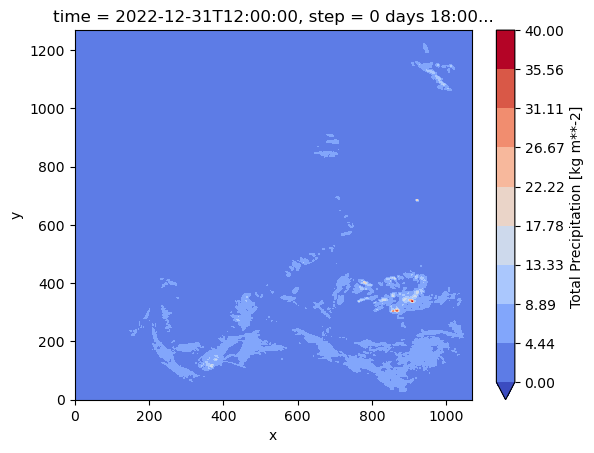

In [23]:
levels=np.linspace(0,40,10)

da_carra.plot.contourf(cmap=cmap,levels=levels)#,x=ds_carra.latitude.values,y=ds_carra.longitude.values)


# Checking some of the daily means


In [24]:
ds = xr.open_dataset(os.path.join(DATADIR,"means_era5","tp_era5_dailymean_1hintervals_202301.nc"))


In [25]:
ds

<xarray.Dataset>
Dimensions:      (time: 31, lat: 101, lon: 261)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-31
    realization  int64 ...
  * lat          (lat) float64 60.0 60.25 60.5 60.75 ... 84.25 84.5 84.75 85.0
  * lon          (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -10.5 -10.25 -10.0
Data variables:
    tp           (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2023-06-27T10:40 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [26]:
ds["tp"].min()

<xarray.DataArray 'tp' ()>
array(0.)
Coordinates:
    realization  int64 ...

In [27]:
ds["tp"].max()

<xarray.DataArray 'tp' ()>
array(0.00268535)
Coordinates:
    realization  int64 ...

In [28]:
ds.attrs["history"]

'2023-06-27T10:40 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-2.27.0 with {"source": "/nfs/compute-0017/data8/adaptor.mars.internal-1687862367.7885869-13610-4-71c48953-32af-4276-9239-a8ef056abca9.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'

In [29]:
#fig = plt.figure()
#plt.figure().clear()


In [30]:
ds_180 = ds.assign_coords(longitude=(((ds.lon + 180) % 360) - 180)).sortby('lon')
# Create Xarray Data Array
da = ds_180['tp']*1000
min_val=da.min()
max_val=da.max()
print(min_val)
print(max_val)
# Create Xarray Data Array
#da_degc = ds['t2m'] - 273.15
#da_degc = da - 273.15
da_tp = da.assign_attrs(da.attrs)
da_tp.attrs['units'] = 'mm'
import matplotlib as mpl
cmap = mpl.cm.coolwarm
#cmap = mpl.cm.RdBu_r
levels=np.linspace(0,3,10)



<xarray.DataArray 'tp' ()>
array(0.)
Coordinates:
    realization  int64 ...
<xarray.DataArray 'tp' ()>
array(2.68534827)
Coordinates:
    realization  int64 ...


In [31]:
da_tp[0,:,:]

<xarray.DataArray 'tp' (lat: 101, lon: 261)>
array([[0.00762939, 0.00653664, 0.00576178, ..., 0.11789799, 0.1188914 ,
        0.12338161],
       [0.00820557, 0.00754992, 0.00729164, ..., 0.11175871, 0.10198355,
        0.09890398],
       [0.00723203, 0.00655651, 0.00580152, ..., 0.10275841, 0.10085106,
        0.09924173],
       ...,
       [0.00452995, 0.00451008, 0.00460943, ..., 0.0132521 , 0.01327197,
        0.01323223],
       [0.00355641, 0.00357628, 0.00365575, ..., 0.01114607, 0.01114607,
        0.0111262 ],
       [0.0013113 , 0.00139078, 0.00145038, ..., 0.0090003 , 0.00909964,
        0.00907977]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2023-01-01
    realization  int64 ...
  * lat          (lat) float64 60.0 60.25 60.5 60.75 ... 84.25 84.5 84.75 85.0
  * lon          (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -10.5 -10.25 -10.0
    longitude    (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -10.5 -10.25 -10.0
Attributes:
    units:    mm

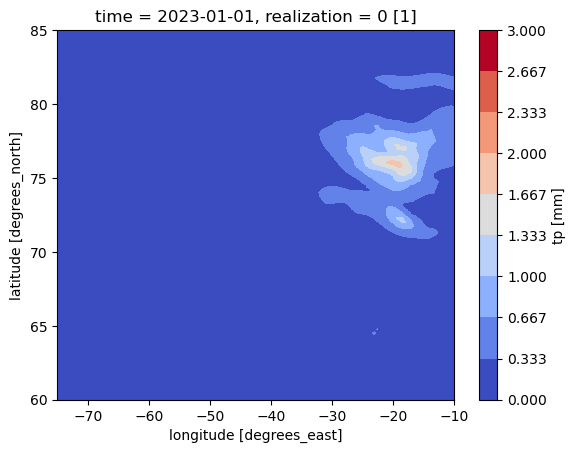

In [32]:
da_tp[0,:,:].plot.contourf(cmap=cmap,levels=levels)

In [33]:
fin_carra=os.path.join(DATADIR,"means_gribmean","tp_carra_20230101.grib2")

carra = mv.read(fin_carra)
ds_carra = carra.to_dataset()
ds_carra

<xarray.Dataset>
Dimensions:     (y: 1269, x: 1069)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    tp          (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2023-06-28T13:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [34]:
ds_carra["tp"].min()

<xarray.DataArray 'tp' ()>
array(-0.00090408)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

In [35]:
ds_carra["tp"].max()

<xarray.DataArray 'tp' ()>
array(102.80924988)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

In [36]:
import cartopy
print(cartopy.__version__)

0.20.2


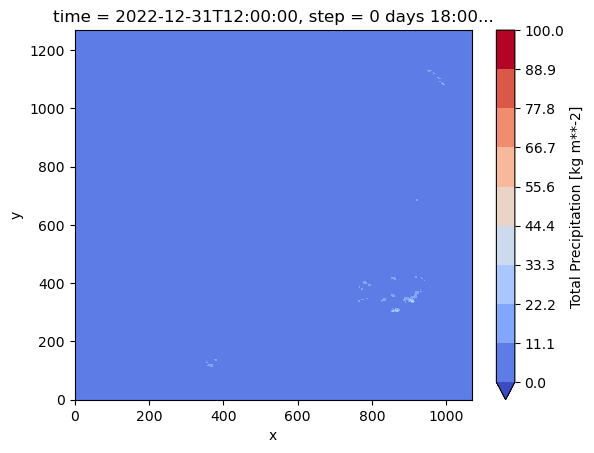

In [37]:
levels=np.linspace(0,100,10)
#proj = ds_read["misc"]["proj"]

#fig = plt.figure(figsize=[12,9])
#ax = plt.axes(projection=proj)
da_carra.plot.contourf(cmap=cmap,levels=levels)#,x=ds_carra.latitude.values,y=ds_carra.longitude.values)


# Using the method for the daily gallery

In [38]:
import copy
import pygrib
import numpy.ma as ma
import datetime

def read_vars(gribfile,params):
    '''
    Reads a file that contains only one time step
    '''
    print("in read_vars")
    ds = {}
    vars = copy.deepcopy(params)
    f = pygrib.open(gribfile)
    was_found=False
    for msg in f:
        for param in vars:
            if vars[param]['param']== str(msg['param']) and vars[param]["level"]==msg["level"] and vars[param]["typeOfLevel"]==msg['typeOfLevel'] and vars[param]["levelType"]==msg["levelType"]:
                print(f'found {vars[param]}')
                vars[param]['msg'] = msg
                was_found=True
        if not was_found:
            #quick check for when it doesnt find anything
            for param in vars:
                print(vars[param]['param'])
                if vars[param]['param']== str(msg['param']):
                    print(f"{param} not found. Printing some info")
                    this_param=msg["param"]
                    this_level=msg["level"]
                    this_tlevel=msg['typeOfLevel']
                    this_ltype=msg["levelType"]
                    print("level :{this_level}")
                    print("typeOfLevel {this_tlevel}")
                    print("levelType {this_ltype}")
                    print("Original params:")
                    print(params)
                    for key in ["param","level","typeOfLevel","levelType"]:
                        new_params = {param:{"param":this_param,"level":this_level,
                                             "typeOfLevel":this_tlevel,"levelType":this_ltype}}
                    print(new_params)
                    sys.exit(0)

    for param in vars:
        msghit = vars[param]['msg']
        nx = msghit['Nx']
        ny = msghit['Ny']
        date = msghit['date']
        hour = msghit['hour']
        fcstep = msghit['step']
        lons = msghit['longitudes'].reshape((ny,nx))
        lats = msghit['latitudes'].reshape((ny,nx))
        lat0 = msghit['LaDInDegrees']
        lon0 = msghit['LoVInDegrees']
        lat1 = msghit['Latin1InDegrees']
        lat2 = msghit['Latin2InDegrees']
        val = ma.masked_values(msghit['values'].reshape((ny,nx)),msghit['missingValue'])
        name = msghit['parameterName']
        vars[param]['field'] = val
        dt = datetime.datetime.strptime(str(date)+str(hour),"%Y%m%d%H")
        lons2 = np.where(lons>180,lons-360,lons)
        lon0 = np.where(lon0>180,lon0-360,lon0)
        proj = ccrs.LambertConformal(central_latitude=lat0,
                                 central_longitude=lon0,
                                 standard_parallels=(lat1, lat2))
        ds['misc'] = {'date':dt,
                      'lons':lons2,
                      'lats':lats,
                      'proj':proj,
                      'fcstep':fcstep}
        ds['params'] = vars

    return ds

In [39]:
params = {'t2m':{"param":"167","level":2,"typeOfLevel":"heightAboveGround","levelType":"sfc"}}
fin_carra=os.path.join(DATADIR,"means_gribmean","t2m_mean.grib2")

ds_read = read_vars(fin_carra,params)
proj = ds_read["misc"]["proj"]
print(proj)

in read_vars
found {'param': '167', 'level': 2, 'typeOfLevel': 'heightAboveGround', 'levelType': 'sfc'}
+proj=lcc +ellps=WGS84 +lon_0=-36.0 +lat_0=72.0 +x_0=0.0 +y_0=0.0 +lat_1=72.0 +lat_2=72.0 +no_defs +type=crs


Using t2m to plot temperature
[[ -6.17557373  -6.14822998  -6.04471436 ...   8.13009033   8.17891846
    8.11348877]
 [ -6.07498779  -6.05252686  -5.94705811 ...   8.15548096   8.21407471
    8.18380127]
 [ -6.11502686  -6.10330811  -5.99100342 ...   8.11641846   8.16915283
    8.14766846]
 ...
 [-27.45780029 -27.49393311 -27.39237061 ...  -3.23319092  -3.15311279
   -3.22440186]
 [-27.59451904 -27.63455811 -27.50760498 ...  -3.28006592  -3.20389404
   -3.26639404]
 [-27.51834717 -27.61697998 -27.51444092 ...  -3.25662842  -3.19510498
   -3.26932373]]


AttributeError: 'GeoAxesSubplot' object has no attribute '_autoscaleXon'

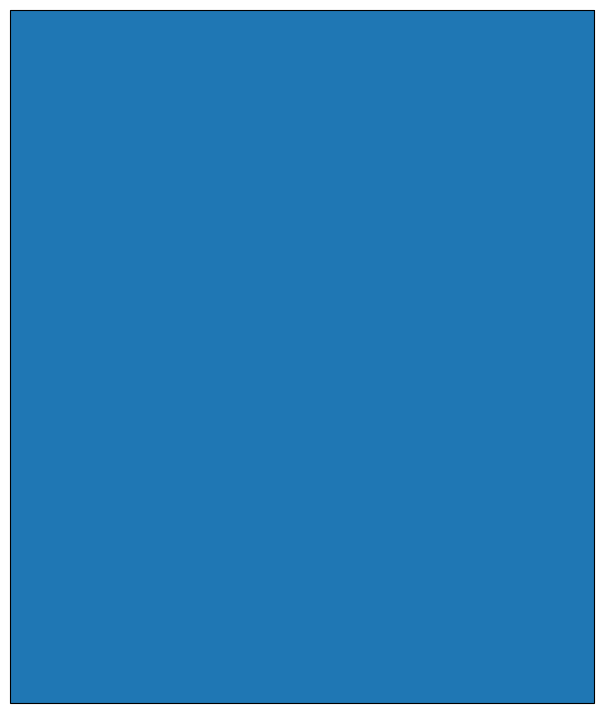

In [40]:
def plot_t2m(ifile,params,suf_png):
    '''
     Plot t2m and wind velocity
    '''
    print(f"Plotting {params} for {ifile}")
    ds = read_vars(ifile,params)
    fig=t2m(ds)
    print(f"Saving plot to {suf_png}")
    plt.savefig(suf_png)
    fig.clf()
    plt.close(fig)
    gc.collect()

def t2m(ds,cmap,levels):
    lons = ds['misc']['lons']
    lats = ds['misc']['lats']
    proj = ds['misc']['proj']
    dt = ds['misc']['date']
    fcstep = ds['misc']['fcstep']

    # Plotting parameters
    t_colors = ['#ffffff','#e6e6e6','#cccccc','#b3b3b3','#ae99ae','#7a667a','#330066','#590080','#8000ff',
                '#0080ff','#00ccff','#00ffff','#26e699','#66bf26','#bfe626','#ffff80','#ffff00','#ffda00',
                '#ffb000','#ff7300','#ff0000','#cc0000','#80002c','#cc3d6e','#ff00ff','#ff80ff','#ffbfff',
                '#e6cce6','#e6e6e6']
    t_levels = np.array([-80,-70,-60,-52,-48,-44,-40,-36,-32,-28,-24,-20,-16,-12,-8,-4,0,
                4,8,12,16,20,24,28,32,36,40,44,48,52,56])
    variable = [key for key in ds["params"].keys()][0]
    print(f"Using {variable} to plot temperature")
    # Fields to plot
    #t2m = ds['params']['t2m']['field'] - 273.15
    t2m = ds['params'][variable]['field'] - 273.15
    print(t2m)
    fig = plt.figure(figsize=[12,9])
    ax = plt.axes(projection=proj)

    CS = ax.contourf(lons,lats,t2m,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels)#,colors=t_colors,levels=t_levels)
    plt.colorbar(CS,shrink=0.5,orientation='vertical')

    #ax.coastlines('50m')
    ax.gridlines()

    #plt.title("T2M \n%s UTC + %dh" % (dt.strftime('%Y-%m-%d %H:00'), fcstep))
    period=dt.strftime('%Y%m')
    plt.title(f"{variable} {period}")

    return fig
levels=np.linspace(-45,45,20)
fig=t2m(ds_read,cmap,levels)    
plt.show()


In [41]:
#fig.clf()
#plt.close(fig)

AttributeError: 'GeoAxesSubplot' object has no attribute '_autoscaleXon'

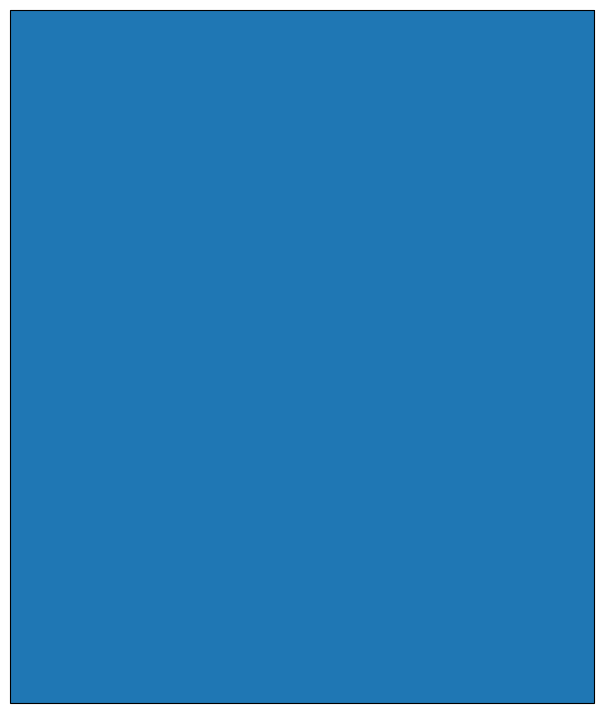

In [42]:
fig = plt.figure(figsize=[12,9])
proj = ds_read['misc']['proj']
ax = plt.axes(projection=proj)
cs=ax.contourf(ds_read['params']["t2m"]['field'],cmap=cmap)
# ax.plot(ds_read['misc']['lons'],ds_read["misc"]["lats"],ds_read['params']["t2m"]['field'] - 273.15)
import matplotlib
norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())


In [43]:
ds_read["params"]["t2m"]["field"]

masked_array(
  data=[[266.97442627, 267.00177002, 267.10528564, ..., 281.28009033,
         281.32891846, 281.26348877],
        [267.07501221, 267.09747314, 267.20294189, ..., 281.30548096,
         281.36407471, 281.33380127],
        [267.03497314, 267.04669189, 267.15899658, ..., 281.26641846,
         281.31915283, 281.29766846],
        ...,
        [245.69219971, 245.65606689, 245.75762939, ..., 269.91680908,
         269.99688721, 269.92559814],
        [245.55548096, 245.51544189, 245.64239502, ..., 269.86993408,
         269.94610596, 269.88360596],
        [245.63165283, 245.53302002, 245.63555908, ..., 269.89337158,
         269.95489502, 269.88067627]],
  mask=False,
  fill_value=9999.0)

In [46]:
# check tmax

In [47]:
ds = xr.open_dataset(os.path.join(DATADIR,'means_gribmean',"max2t_carra_20230101.grib2"))


In [50]:
ds["mx2t"]

<xarray.DataArray 'mx2t' (y: 1269, x: 1069)>
[1356561 values with dtype=float32]
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes: (12/33)
    GRIB_paramId:                             201
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1356561
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            max
    ...                                       ...
    GRIB_name:                                Maximum temperature at 2 metres...
    GRIB_shortName:                           mx2t
    GRIB_units:                               K
    long_name:                                Maximum temperature at 2 metres...
    units:                                    K
    standard_name:                            air_temperature

In [51]:
ds["mx2t"].min()

<xarray.DataArray 'mx2t' ()>
array(232.90240479)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    valid_time         datetime64[ns] ...

In [53]:
da_degc = ds['mx2t'] - 273.15
da_degc = da_degc.assign_attrs(da.attrs)
da_degc.attrs['units'] = '° C'

In [56]:
da_degc.min()

<xarray.DataArray 'mx2t' ()>
array(-40.24758911)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    valid_time         datetime64[ns] ...

In [57]:
da_degc.max()

<xarray.DataArray 'mx2t' ()>
array(9.41116333)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    valid_time         datetime64[ns] ...

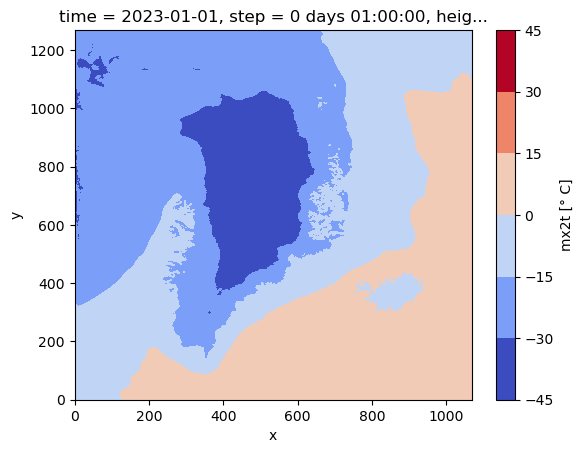

In [58]:
da_degc.plot.contourf(cmap=cmap)#,levels=levels)#,x=ds_carra.latitude.values,y=ds_carra.longitude.values)
